# Setup

In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import scipy

In [0]:
def setting(n, p, p1, noise=1,npseed=0):
    np.random.seed(npseed)
    data=np.empty((n, p))

    for i in range(n):
        data[i,:] = np.random.normal(0,1, size = (1, p))

    beta1 = np.ones(p1)
    # beta2 = torch.cat((torch.ones(1), torch.zeros(p-p1-1)), dim=0)
    beta2 = np.zeros(p-p1)
    beta=np.concatenate((beta1,beta2),axis=0)

    y = np.matmul(data, beta).reshape(n, 1) + np.random.normal(0, noise, size = (n, 1))


    return y, data,beta

def newset(y, X, T):
    new_y = torch.tensor(np.concatenate((y, X), axis=1)).float()
    new_data = torch.tensor(T).float()
    return new_y, new_data

In [0]:
def simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=3000,p1=300,lam=2,alpha=0.05,verbose=1,lamj=2):
  beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plm, beta_dblasso=[],[],[],[],[],[]
  y_truth, y_ols,y_lasso, y_lassols, y_plm, y_dblasso=[],[],[],[],[],[]
  y_truth_te, y_ols_te,y_lasso_te, y_lassols_te, y_plm_te, y_dblasso_te=[],[],[],[],[],[]
  conf_ols,conf_lassols,conf_plm,conf_dblasso=[],[],[],[]
  time_plm,time_dblasso=[],[]

  for i in range(Nrun):
      y, X,beta = setting(n=n, p=p, p1=p1, noise=sigma, npseed=i)
      np.random.seed(i)
      torch.manual_seed(i)

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=i)

      # LASSO
      lasso = Lasso(alpha = lam,fit_intercept=False) # lasso: alpha=1 prediction bad; alpha=0.1 no zero; mixture 0.15
      lasso.fit(X_train, y_train)
      lasso_coef=lasso.coef_
      print('Run ',i,', Lasso selects ',sum(lasso_coef!=0),' features.')
      beta_truth.append(beta[lasso_coef!=0])
      y_truth.append(y_train.flatten())
      y_truth_te.append(y_test.flatten())

      beta_lasso.append(lasso_coef[lasso_coef!=0])
      y_lasso.append(X_train.dot(lasso_coef))
      y_lasso_te.append(X_test.dot(lasso_coef))

      new_p1 = sum(lasso_coef!=0)
      Z_train = X_train[:, lasso_coef!=0]
      T_train = X_train[:, lasso_coef==0]
      Z_test = X_test[:, lasso_coef!=0]
      T_test = X_test[:, lasso_coef==0]

      # OLS if low dimension
      if n>p:
        ols = sm.OLS(y_train, X_train).fit()
        conf_ols.append(ols.conf_int(alpha=alpha, cols=None)[lasso_coef!=0])
        beta_ols.append(ols.params[lasso_coef!=0])
        y_ols.append(X_train.dot(ols.params))
        y_ols_te.append(X_test.dot(ols.params))

      # LASSO+OLS
      lasso_ols = sm.OLS(y_train, Z_train).fit()
      conf_lassols.append(lasso_ols.conf_int(alpha=alpha, cols=None))
      beta_lassols.append(lasso_ols.params)
      y_lassols.append(Z_train.dot(lasso_ols.params))
      y_lassols_te.append(Z_test.dot(lasso_ols.params))


      #LASSO+PLM
      start_time = time.time()
      yZ_train, T_train = newset(y_train, Z_train, T_train)
      yZ_test, T_test = newset(y_test, Z_test, T_test)


      max_epoch = 1000
      lr = 2e-4
      D_in, H, D_out = p-new_p1, 1000, new_p1+1 #p1_new will be selected by lasso later
      batch_size = n

      Train_dataset = TensorDataset(T_train, yZ_train)
      trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
      Test_dataset = TensorDataset(T_test, yZ_test)
      testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=True)

      model = nn.Sequential(
          nn.Linear(D_in, H),
          nn.ReLU(),
          nn.Linear(H, D_out),
      )

      optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
      criterion = nn.MSELoss()
      old_val_error=10000
      patience=0

      for epoch in range(max_epoch):
          for batch_T, batch_yZ in trainloader:

              optimizer.zero_grad()
              batch_yZ_pred = model(batch_T)
              batch_loss = criterion(batch_yZ_pred, batch_yZ)

              #print(epoch+1, '---', batch_loss)

              batch_loss.backward()
              optimizer.step()
          with torch.no_grad():
              yZ_pred = model(T_test)
              val_loss = criterion(yZ_pred, yZ_test)
          #early stopping
          if val_loss.item()<old_val_error:
              old_val_error=val_loss.item()
              patience=0
          else:
              patience+=1
          
          if patience>0:
              break

      whole_pred=model(T_train).detach().numpy()
      mean_conditional_y=whole_pred[:,0]
      mean_conditional_Z=whole_pred[:,1:]
      whole_pred_te=model(T_test).detach().numpy()
      mean_conditional_y_te=whole_pred_te[:,0]
      mean_conditional_Z_te=whole_pred_te[:,1:]

      PLM_ols = sm.OLS(y_train-mean_conditional_y.reshape(-1,1), Z_train-mean_conditional_Z).fit()
      conf_plm.append(PLM_ols.conf_int(alpha=alpha, cols=None))
      beta_plm.append(PLM_ols.params)
      y_plm.append(mean_conditional_y.flatten()+(Z_train-mean_conditional_Z).dot(PLM_ols.params))
      y_plm_te.append(mean_conditional_y_te.flatten()+(Z_test-mean_conditional_Z_te).dot(PLM_ols.params))
      time_plm.append(time.time() - start_time)


      #DBLASSO
      start_time = time.time()
      C = np.zeros((p ,p))
      tau_2 = np.zeros((p))
      #each row in C is the trained coef_ of X_j
      r=list(range(p))
      for j in range(p):
          not_j=r[:j]+r[j+1:]
          lasso = Lasso(alpha=lamj,fit_intercept=False)
          lasso.fit(X_train[:,not_j], X_train[:,j].reshape(int(n*(1-split_size)), 1))
          node_beta=lasso.coef_
          # print(np.mean(node_beta!=0))
          C[j,not_j] = -node_beta
          C[j, j] = 1
          tau_2[j] = MSE(X_train[:,j],X_train[:,not_j].dot(node_beta))+lamj*sum(abs(node_beta))

      T_2 = np.diag(tau_2**(-1))
      Theta_hat = np.matmul(T_2, C)
      n_tr=len(X_train)
      db_lasso = lasso_coef + \
      Theta_hat.dot(X_train.T.dot(y_train.reshape(-1,)-X_train.dot(lasso_coef))) /n_tr
      Sigma_hat = X_train.T.dot(X_train)/n_tr
      temp=np.diag((Theta_hat.dot(Sigma_hat)).dot(Theta_hat.T))
      c=scipy.stats.norm.ppf(1-alpha/2)*sigma*np.sqrt(temp/n_tr)
      conf_dblasso.append(np.vstack(((db_lasso-c)[lasso_coef!=0],(db_lasso+c)[lasso_coef!=0])).T)
      beta_dblasso.append(db_lasso[lasso_coef!=0])
      y_dblasso.append(X_train.dot(db_lasso))
      y_dblasso_te.append(X_test.dot(db_lasso))
      time_dblasso.append(time.time() - start_time)
      
      if verbose==1:
        #Output
        print('LASSO selects ',sum(lasso_coef!=0),' variables out of ', p1)
        print('Truth: ', beta[lasso_coef!=0]) #truth
        print('Lasso: ', lasso_coef[lasso_coef!=0]) #lasso
        print('OLS post-Lasso: ', lasso_ols.params)# lasso+ols
        print('DebiNet: ', PLM_ols.params)# lasso+PLM
        print('debised Lasso: ', db_lasso[lasso_coef!=0]) #debiased lasso

  return ([beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plm, beta_dblasso],[y_truth, y_ols,y_lasso, y_lassols, y_plm, y_dblasso],
          [beta_truth, conf_ols,conf_lassols,conf_plm,conf_dblasso],[time_plm,time_dblasso],[y_truth_te, y_ols_te,y_lasso_te, y_lassols_te, y_plm_te, y_dblasso_te],db_lasso)

In [0]:
def est_plot(beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plm, beta_dblasso,s=20,save=None):
  from matplotlib import pyplot as plt
  plt.plot(beta_truth)
  if len(beta_ols)!=0:
    plt.scatter(np.arange(len(beta_truth)),beta_ols,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_lasso,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_lassols,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_plm,s=s)
  plt.scatter(np.arange(len(beta_truth)),beta_dblasso,s=s)
  if len(beta_ols)!=0:
    plt.legend(['Truth','OLS','Lasso','OLS post-Lasso','DebiNet', 'debiased Lasso'])
  else:
    plt.legend(['Truth','Lasso','OLS post-Lasso','DebiNet', 'debiased Lasso'])
  plt.ylim(-3,3)
  if save:
    plt.savefig(save,format='pdf')
  plt.show()
  return None

def est_error(beta_truth, beta_ols,beta_lasso, beta_lassols, beta_plm, beta_dblasso):
  Nrun=len(beta_truth)
  if len(beta_ols)!=0:
    ols_record=0
    for i in range(Nrun):
      ols_record+=MSE(beta_truth[i],beta_ols[i])/Nrun
  
  lasso_record,lassols_record,plm_record,dblasso_record=0,0,0,0
  for i in range(Nrun):
    lasso_record+=MSE(beta_truth[i],beta_lasso[i])/Nrun
    lassols_record+=MSE(beta_truth[i],beta_lassols[i])/Nrun
    plm_record+=MSE(beta_truth[i],beta_plm[i])/Nrun
    dblasso_record+=MSE(beta_truth[i],beta_dblasso[i])/Nrun
  
  if len(beta_ols)!=0:
    return ols_record,lasso_record,lassols_record,plm_record,dblasso_record
  return lasso_record,lassols_record,plm_record,dblasso_record

def conf_plot(conf, run = 0,save=None):
  conf_nonzero = []
  conf_zero = []
  beta_nonzero=[]
  beta_zero=[]
  beta_truth=conf[0][run]


  if conf[1]!=[]:
    name = ['OLS','OLS post-Lasso', 'DebiNet', 'debiased Lasso']
  else:
    name = ['OLS post-Lasso', 'DebiNet', 'debiased Lasso']

  for i in range(1,len(conf)):
    if conf[i] !=[]:
      confi=conf[i][run]
      # print(confi[beta_truth!=0]);print(confi[beta_truth==0])
      conf_nonzero.append(np.mean(confi[beta_truth!=0][:,1]-confi[beta_truth!=0][:,0])/2)
      conf_zero.append(np.mean(confi[beta_truth==0][:,1]-confi[beta_truth==0][:,0])/2)
      beta_nonzero.append(np.mean(confi[beta_truth!=0]))
      beta_zero.append(np.mean(confi[beta_truth==0]))
      

  plt.errorbar(np.arange(len(beta_nonzero)), beta_nonzero, yerr=np.asarray(conf_nonzero).T,ls='none',uplims=True,lolims=True,marker='.')
  plt.errorbar(np.arange(len(beta_zero))+0.2, beta_zero, yerr=np.asarray(conf_zero).T,ls='none',uplims=True,lolims=True,marker='.')
  plt.axhline(y=0,linestyle='dashed',color='C1')
  plt.axhline(y=1,linestyle='dashed',color='C0')
  plt.xticks([r+0.1 for r in range(len(name))], name)
  if save:
    plt.savefig(save,format='pdf')
  plt.show()
  return None

def cov_rate(conf):
  beta_truth = conf[0]
  Nrun=len(beta_truth)
  cov_rate,cov_len = [],[]
  for i in range(1, len(conf)):
    conff = conf[i]
    if conff !=[]:
      count = 0
      length = 0
      for j in range(Nrun):         
        conff_min, conff_max = conff[j][:,0], conff[j][:,1]
        # print(beta_truth[j], conff_min)
        mask = (beta_truth[j]>conff_min) * (beta_truth[j]<conff_max)
        count += np.mean(mask)
        length += np.mean(conff_max-conff_min)
      cov_rate.append(count/Nrun)  
      cov_len.append(length/Nrun)
  return cov_rate,cov_len

# High dimension High Sparsity



In [12]:
start=time.time() # 60min
outputs0=simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=3000,p1=300,lam=2,alpha=0.05,verbose=0,lamj=2)
print(time.time()-start)

Run  0 , Lasso selects  10  features.
Run  1 , Lasso selects  20  features.
Run  2 , Lasso selects  19  features.
Run  3 , Lasso selects  14  features.
Run  4 , Lasso selects  15  features.
Run  5 , Lasso selects  14  features.
Run  6 , Lasso selects  20  features.
Run  7 , Lasso selects  15  features.
Run  8 , Lasso selects  18  features.
Run  9 , Lasso selects  21  features.
Run  10 , Lasso selects  15  features.
Run  11 , Lasso selects  16  features.
Run  12 , Lasso selects  23  features.
Run  13 , Lasso selects  25  features.
Run  14 , Lasso selects  18  features.
Run  15 , Lasso selects  13  features.
Run  16 , Lasso selects  13  features.
Run  17 , Lasso selects  13  features.
Run  18 , Lasso selects  13  features.
Run  19 , Lasso selects  14  features.
3345.1120796203613


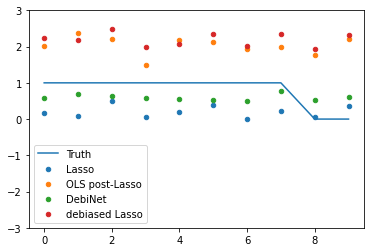



Lasso estimation error:  0.5408341721701279
LassoOLS estimation error:  1.3753528884494166
dbLasso estimation error:  2.0641810726102268
LassoPLM estimation error:  0.448782429804188




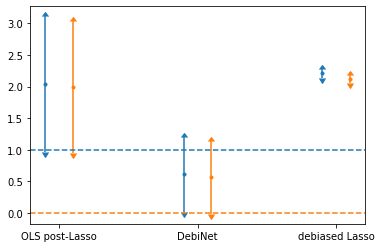



LassoOLS coverage:  0.5776963653559763  with width  2.142277756532218
LassoPLM coverage:  0.8194540448110244  with width  1.6836420674852914
dbLasso coverage:  0.0  with width  0.13792024164127248


Lasso prediction error:  285.94807404824274
LassoOLS prediction error:  230.72864244308496
LassoPLM prediction error:  145.3177721060986
dbLasso prediction error:  5027.757313918683


Lasso generalization error:  296.5134672500838
LassoOLS generalization error:  308.34445082072244
LassoPLM generalization error:  280.39722568045
dbLasso generalization error:  1067.417405694887


LassoPLM time:  61.0169615149498
dbLasso time:  106.0146800160408


In [13]:
est_plot(outputs0[0][0][0],[],outputs0[0][2][0],outputs0[0][3][0],outputs0[0][4][0],outputs0[0][5][0],save='high1.pdf')
print('\n')

### estimation error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs0[0][0],[],outputs0[0][2],outputs0[0][3],outputs0[0][4],outputs0[0][5])
print('Lasso estimation error: ',lasso_record)
print('LassoOLS estimation error: ',lassols_record)
print('dbLasso estimation error: ',dblasso_record)
print('LassoPLM estimation error: ',plm_record)
print('\n')

conf_plot(outputs0[2],save='highconfidence1.pdf')
print('\n')

### coverage
print('LassoOLS coverage: ',cov_rate(outputs0[2])[0][0],' with width ',cov_rate(outputs0[2])[1][0])
print('LassoPLM coverage: ',cov_rate(outputs0[2])[0][1],' with width ',cov_rate(outputs0[2])[1][1])
print('dbLasso coverage: ',cov_rate(outputs0[2])[0][2],' with width ',cov_rate(outputs0[2])[1][2])
print('\n')

### prediction error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs0[1][0],[],outputs0[1][2],outputs0[1][3],outputs0[1][4],outputs0[1][5])
print('Lasso prediction error: ',lasso_record)
print('LassoOLS prediction error: ',lassols_record)
print('LassoPLM prediction error: ',plm_record)
print('dbLasso prediction error: ',dblasso_record)
print('\n')

### generalization error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs0[4][0],[],outputs0[4][2],outputs0[4][3],outputs0[4][4],outputs0[4][5])
print('Lasso generalization error: ',lasso_record)
print('LassoOLS generalization error: ',lassols_record)
print('LassoPLM generalization error: ',plm_record)
print('dbLasso generalization error: ',dblasso_record)
print('\n')

### time
print('LassoPLM time: ',np.mean(outputs0[3][0]))
print('dbLasso time: ',np.mean(outputs0[3][1]))

# High dimension Low Sparsity

In [14]:
start=time.time() # 60min
outputs1=simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=3000,p1=10,lam=0.5,alpha=0.05,verbose=0,lamj=0.5)
print(time.time()-start)

Run  0 , Lasso selects  10  features.
Run  1 , Lasso selects  10  features.
Run  2 , Lasso selects  10  features.
Run  3 , Lasso selects  10  features.
Run  4 , Lasso selects  10  features.
Run  5 , Lasso selects  10  features.
Run  6 , Lasso selects  10  features.
Run  7 , Lasso selects  10  features.
Run  8 , Lasso selects  10  features.
Run  9 , Lasso selects  10  features.
Run  10 , Lasso selects  10  features.
Run  11 , Lasso selects  10  features.
Run  12 , Lasso selects  10  features.
Run  13 , Lasso selects  10  features.
Run  14 , Lasso selects  10  features.
Run  15 , Lasso selects  10  features.
Run  16 , Lasso selects  10  features.
Run  17 , Lasso selects  10  features.
Run  18 , Lasso selects  10  features.
Run  19 , Lasso selects  10  features.
2588.367693424225


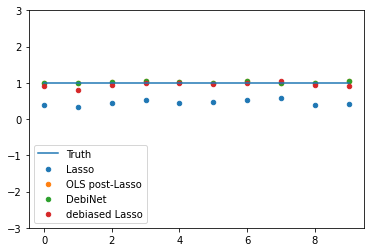



Lasso estimation error:  0.263249236733146
LassoOLS estimation error:  0.0011307038378469338
dbLasso estimation error:  0.004312279149039556
LassoPLM estimation error:  0.0011515593474397477




/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


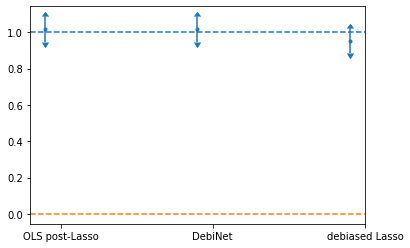



LassoOLS coverage:  0.9649999999999999  with width  0.14118975498258415
LassoPLM coverage:  0.9649999999999999  with width  0.14158360143488657
dbLasso coverage:  0.7049999999999998  with width  0.13857821900997566


Lasso prediction error:  3.543661311614381
LassoOLS prediction error:  1.0111745820694913
LassoPLM prediction error:  1.0061547654713148
dbLasso prediction error:  54.99229542845435


Lasso generalization error:  3.610578958135436
LassoOLS generalization error:  0.9956287406755958
LassoPLM generalization error:  0.9992817123226314
dbLasso generalization error:  14.002223249208551


LassoPLM time:  21.405095267295838
dbLasso time:  107.78525904417037


In [15]:
est_plot(outputs1[0][0][0],[],outputs1[0][2][0],outputs1[0][3][0],outputs1[0][4][0],outputs1[0][5][0],save='high2.pdf')
print('\n')

### estimation error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs1[0][0],[],outputs1[0][2],outputs1[0][3],outputs1[0][4],outputs1[0][5])
print('Lasso estimation error: ',lasso_record)
print('LassoOLS estimation error: ',lassols_record)
print('dbLasso estimation error: ',dblasso_record)
print('LassoPLM estimation error: ',plm_record)
print('\n')

conf_plot(outputs1[2],save='highconfidence2.pdf')
print('\n')

### coverage
print('LassoOLS coverage: ',cov_rate(outputs1[2])[0][0],' with width ',cov_rate(outputs1[2])[1][0])
print('LassoPLM coverage: ',cov_rate(outputs1[2])[0][1],' with width ',cov_rate(outputs1[2])[1][1])
print('dbLasso coverage: ',cov_rate(outputs1[2])[0][2],' with width ',cov_rate(outputs1[2])[1][2])
print('\n')

### prediction error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs1[1][0],[],outputs1[1][2],outputs1[1][3],outputs1[1][4],outputs1[1][5])
print('Lasso prediction error: ',lasso_record)
print('LassoOLS prediction error: ',lassols_record)
print('LassoPLM prediction error: ',plm_record)
print('dbLasso prediction error: ',dblasso_record)
print('\n')

### generalization error
lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs1[4][0],[],outputs1[4][2],outputs1[4][3],outputs1[4][4],outputs1[4][5])
print('Lasso generalization error: ',lasso_record)
print('LassoOLS generalization error: ',lassols_record)
print('LassoPLM generalization error: ',plm_record)
print('dbLasso generalization error: ',dblasso_record)
print('\n')

### time
print('LassoPLM time: ',np.mean(outputs1[3][0]))
print('dbLasso time: ',np.mean(outputs1[3][1]))

# Low dimension High Sparsity

In [20]:
start=time.time() #4min
outputs2=simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=500,p1=400,lam=1,alpha=0.05,verbose=0,lamj=1)
print(time.time()-start)

Run  0 , Lasso selects  143  features.
Run  1 , Lasso selects  150  features.
Run  2 , Lasso selects  150  features.
Run  3 , Lasso selects  155  features.
Run  4 , Lasso selects  142  features.
Run  5 , Lasso selects  147  features.
Run  6 , Lasso selects  157  features.
Run  7 , Lasso selects  159  features.
Run  8 , Lasso selects  156  features.
Run  9 , Lasso selects  151  features.
Run  10 , Lasso selects  141  features.
Run  11 , Lasso selects  152  features.
Run  12 , Lasso selects  147  features.
Run  13 , Lasso selects  152  features.
Run  14 , Lasso selects  150  features.
Run  15 , Lasso selects  134  features.
Run  16 , Lasso selects  154  features.
Run  17 , Lasso selects  152  features.
Run  18 , Lasso selects  147  features.
Run  19 , Lasso selects  148  features.
218.01565670967102


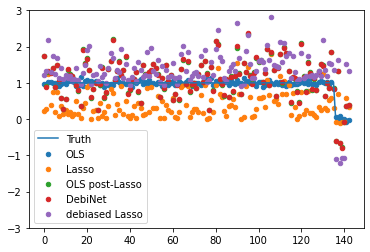



OLS estimation error:  0.0032994593474855493
Lasso estimation error:  0.42714267692236035
LassoOLS estimation error:  0.22657984351217844
dbLasso estimation error:  0.34454028866967734
LassoPLM estimation error:  0.2261037387072071




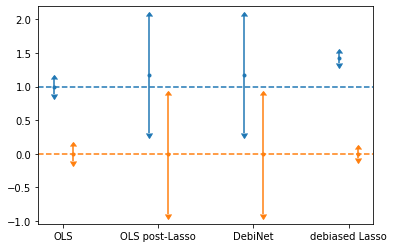



OLS coverage:  0.9554733427499009  with width  0.22876167699397204
LassoOLS coverage:  0.9330408392286567  with width  1.742580023598516
LassoPLM coverage:  0.9334283106455373  with width  1.7430512576770432
dbLasso coverage:  0.10397843665078747  with width  0.1384165480383637


OLS prediction error:  0.3822605589066343
Lasso prediction error:  212.9929526028596
LassoOLS prediction error:  104.79079237337858
LassoPLM prediction error:  104.83737632751489
dbLasso prediction error:  136.93989120571126


OLS prediction error:  2.626240066007529
Lasso generalization error:  328.22334624361974
LassoOLS generalization error:  300.0720455885826
LassoPLM generalization error:  300.14047800981535
dbLasso generalization error:  159.1202396198275


LassoPLM time:  7.72103773355484
dbLasso time:  2.6748558402061464


In [25]:
est_plot(outputs2[0][0][0],outputs2[0][1][0],outputs2[0][2][0],outputs2[0][3][0],outputs2[0][4][0],outputs2[0][5][0],save='low1.pdf')
print('\n')

### estimation error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs2[0][0],outputs2[0][1],outputs2[0][2],outputs2[0][3],outputs2[0][4],outputs2[0][5])
print('OLS estimation error: ',ols_record)
print('Lasso estimation error: ',lasso_record)
print('LassoOLS estimation error: ',lassols_record)
print('dbLasso estimation error: ',dblasso_record)
print('LassoPLM estimation error: ',plm_record)
print('\n')

conf_plot(outputs2[2],save='lowconfidence1.pdf')
print('\n')

### coverage
print('OLS coverage: ',cov_rate(outputs2[2])[0][0],' with width ',cov_rate(outputs2[2])[1][0])
print('LassoOLS coverage: ',cov_rate(outputs2[2])[0][1],' with width ',cov_rate(outputs2[2])[1][1])
print('LassoPLM coverage: ',cov_rate(outputs2[2])[0][2],' with width ',cov_rate(outputs2[2])[1][2])
print('dbLasso coverage: ',cov_rate(outputs2[2])[0][3],' with width ',cov_rate(outputs2[2])[1][3])
print('\n')

### prediction error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs2[1][0],outputs2[1][1],outputs2[1][2],outputs2[1][3],outputs2[1][4],outputs2[1][5])
print('OLS prediction error: ',ols_record)
print('Lasso prediction error: ',lasso_record)
print('LassoOLS prediction error: ',lassols_record)
print('LassoPLM prediction error: ',plm_record)
print('dbLasso prediction error: ',dblasso_record)
print('\n')

### generalization error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs2[4][0],outputs2[4][1],outputs2[4][2],outputs2[4][3],outputs2[4][4],outputs2[4][5])
print('OLS prediction error: ',ols_record)
print('Lasso generalization error: ',lasso_record)
print('LassoOLS generalization error: ',lassols_record)
print('LassoPLM generalization error: ',plm_record)
print('dbLasso generalization error: ',dblasso_record)
print('\n')

### time
print('LassoPLM time: ',np.mean(outputs2[3][0]))
print('dbLasso time: ',np.mean(outputs2[3][1]))

# Low dimension Low Sparsity

In [22]:
start=time.time() # 3min
outputs3=simulations(Nrun=20,split_size=0.2,sigma=1,n=1000,p=500,p1=100,lam=1,alpha=0.05,verbose=0,lamj=1)
print(time.time()-start)

Run  0 , Lasso selects  38  features.
Run  1 , Lasso selects  57  features.
Run  2 , Lasso selects  43  features.
Run  3 , Lasso selects  53  features.
Run  4 , Lasso selects  35  features.
Run  5 , Lasso selects  41  features.
Run  6 , Lasso selects  31  features.
Run  7 , Lasso selects  46  features.
Run  8 , Lasso selects  42  features.
Run  9 , Lasso selects  39  features.
Run  10 , Lasso selects  49  features.
Run  11 , Lasso selects  51  features.
Run  12 , Lasso selects  45  features.
Run  13 , Lasso selects  40  features.
Run  14 , Lasso selects  37  features.
Run  15 , Lasso selects  28  features.
Run  16 , Lasso selects  45  features.
Run  17 , Lasso selects  40  features.
Run  18 , Lasso selects  38  features.
Run  19 , Lasso selects  45  features.
205.23180747032166


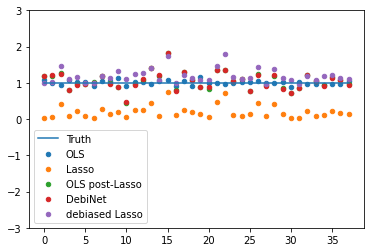



OLS estimation error:  0.0032400061440429626
Lasso estimation error:  0.60143829353969
LassoOLS estimation error:  0.048029556184959625
dbLasso estimation error:  0.10616212098209074
LassoPLM estimation error:  0.04789918782723503




/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


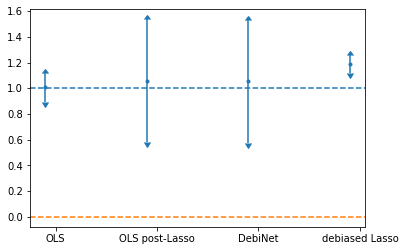



OLS coverage:  0.9621939440757235  with width  0.22860415010971571
LassoOLS coverage:  0.9585662112800767  with width  0.9330543008102291
LassoPLM coverage:  0.9585662112800767  with width  0.9332511942166797
dbLasso coverage:  0.17515149527579926  with width  0.13817656301115455


OLS prediction error:  0.38226055890663413
Lasso prediction error:  74.77497909362795
LassoOLS prediction error:  41.002943590545094
LassoPLM prediction error:  41.00256769291872
dbLasso prediction error:  66.39170454657842


OLS prediction error:  2.6262400660075307
Lasso generalization error:  87.97388066366213
LassoOLS generalization error:  62.8548091542857
LassoPLM generalization error:  62.885493932801225
dbLasso generalization error:  49.340748618955935


LassoPLM time:  7.049517405033112
dbLasso time:  2.7336561560630797


In [27]:
est_plot(outputs3[0][0][0],outputs3[0][1][0],outputs3[0][2][0],outputs3[0][3][0],outputs3[0][4][0],outputs3[0][5][0],save='low2.pdf')
print('\n')

### estimation error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs3[0][0],outputs3[0][1],outputs3[0][2],outputs3[0][3],outputs3[0][4],outputs3[0][5])
print('OLS estimation error: ',ols_record)
print('Lasso estimation error: ',lasso_record)
print('LassoOLS estimation error: ',lassols_record)
print('dbLasso estimation error: ',dblasso_record)
print('LassoPLM estimation error: ',plm_record)
print('\n')

conf_plot(outputs3[2],save='lowconfidence2.pdf')
print('\n')

### coverage
print('OLS coverage: ',cov_rate(outputs3[2])[0][0],' with width ',cov_rate(outputs3[2])[1][0])
print('LassoOLS coverage: ',cov_rate(outputs3[2])[0][1],' with width ',cov_rate(outputs3[2])[1][1])
print('LassoPLM coverage: ',cov_rate(outputs3[2])[0][2],' with width ',cov_rate(outputs3[2])[1][2])
print('dbLasso coverage: ',cov_rate(outputs3[2])[0][3],' with width ',cov_rate(outputs3[2])[1][3])
print('\n')

### prediction error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs3[1][0],outputs3[1][1],outputs3[1][2],outputs3[1][3],outputs3[1][4],outputs3[1][5])
print('OLS prediction error: ',ols_record)
print('Lasso prediction error: ',lasso_record)
print('LassoOLS prediction error: ',lassols_record)
print('LassoPLM prediction error: ',plm_record)
print('dbLasso prediction error: ',dblasso_record)
print('\n')

### generalization error
ols_record,lasso_record,lassols_record,plm_record,dblasso_record=est_error(outputs3[4][0],outputs3[4][1],outputs3[4][2],outputs3[4][3],outputs3[4][4],outputs3[4][5])
print('OLS prediction error: ',ols_record)
print('Lasso generalization error: ',lasso_record)
print('LassoOLS generalization error: ',lassols_record)
print('LassoPLM generalization error: ',plm_record)
print('dbLasso generalization error: ',dblasso_record)
print('\n')

### time
print('LassoPLM time: ',np.mean(outputs3[3][0]))
print('dbLasso time: ',np.mean(outputs3[3][1]))

# Save outputs

In [0]:
import pickle
pickle_out = open("outputs.pickle","wb")
pickle.dump(outputs0, pickle_out)
pickle.dump(outputs1, pickle_out)
pickle.dump(outputs2, pickle_out)
pickle.dump(outputs3, pickle_out)
pickle_out.close()